In [7]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error

from scipy import linalg
import yfinance as yf
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate


## Part 1A: Kalman Filters in Time Series Analysis

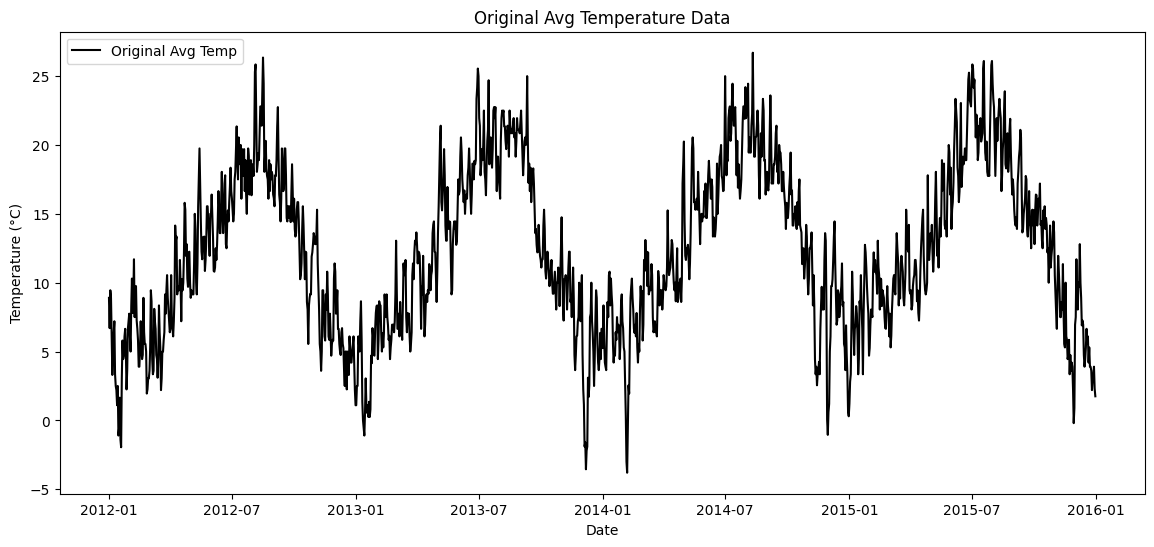

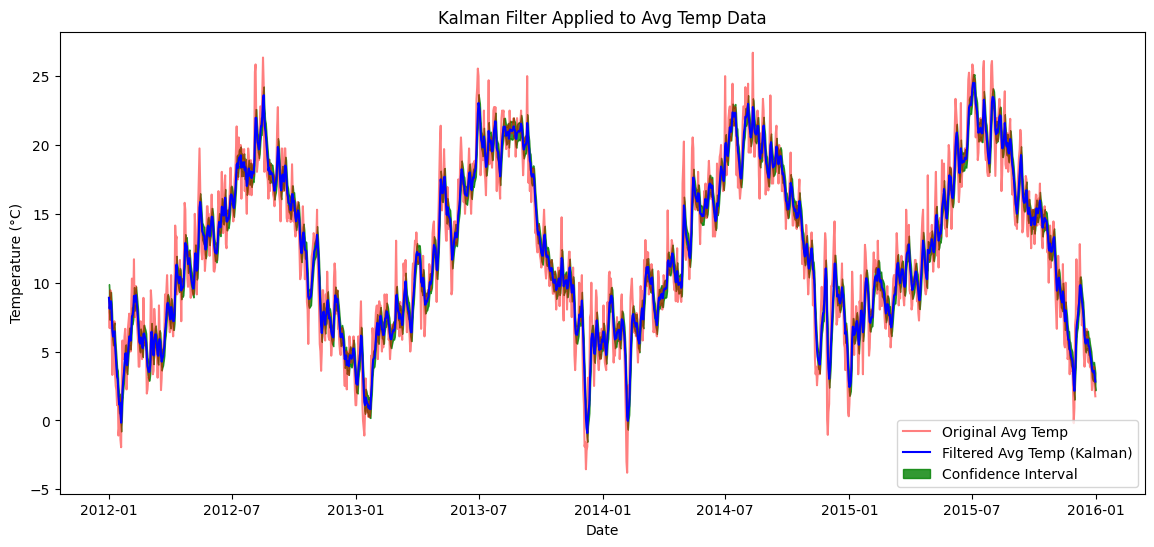

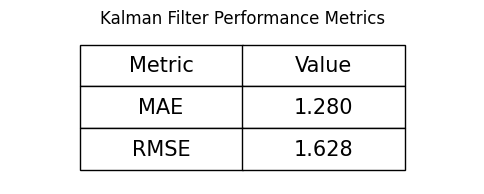

In [13]:
class KalmanFilter:
    def __init__(self, alpha, q, r, initial_state, initial_variance):
        """
        Initializes the Kalman filter with parameters.
        
        Args:
            alpha (float): State transition coefficient.
            q (float): Process noise standard deviation.
            r (float): Measurement noise standard deviation.
            initial_state (float): Initial state estimate.
            initial_variance (float): Initial error covariance.
        """
        self.alpha = alpha
        self.q = q
        self.r = r
        self.mu = initial_state
        self.sigma = initial_variance

    def filter(self, data):
        """
        Applies the Kalman filter to the input data.
        
        Args:
            data (np.array): The data array to filter.
        
        Returns:
            mu_filtered (np.array): Array of filtered state estimates.
            sigma_filtered (np.array): Array of filtered variances.
        
        TODO:
        - Implement the prediction and update steps of the Kalman filter.
        """
        T = len(data)
        mu_filtered = np.zeros(T)
        sigma_filtered = np.zeros(T)
        mu_filtered[0] = self.mu
        sigma_filtered[0] = self.sigma

        for t in range(1, T):
            # TODO: Implement prediction step
            mu_prior = self.alpha * mu_filtered[t - 1]
            sigma_prior = (self.alpha**2) * sigma_filtered[t - 1] + self.q**2
            
            K = sigma_prior / (sigma_prior + self.r**2)
            mu_filtered[t] = mu_prior + K * (data[t] - mu_prior)
            sigma_filtered[t] = (1 - K) * sigma_prior

        return mu_filtered, sigma_filtered

    def plot_results(self, dates, data, mu_filtered, sigma_filtered):
        """
        Plots the original and filtered data along with the confidence interval.
        
        Args:
            dates (pd.Index): Date index for the data.
            data (np.array): Original data.
            mu_filtered (np.array): Filtered state estimates.
            sigma_filtered (np.array): Filtered variances.
        """
        plt.figure(figsize=(14, 6))
        plt.plot(dates, data, label='Original Avg Temp', color='red', alpha=0.5)
        plt.plot(dates, mu_filtered, label='Filtered Avg Temp (Kalman)', color='blue')
        plt.fill_between(dates, mu_filtered + sigma_filtered, mu_filtered - sigma_filtered, color='green', alpha=0.8, label='Confidence Interval')
        plt.title('Kalman Filter Applied to Avg Temp Data')
        plt.xlabel('Date')
        plt.ylabel('Temperature (°C)')
        plt.legend()
        plt.show()

# Main function with TODOs for students to complete
if __name__ == "__main__":
    # TODO: Load the dataset and preprocess it
    # Load dataset
    weather_df = pd.read_csv(
        "seattle-weather.csv",
        parse_dates=['date'],
        index_col='date'
    )
    # Select 'temp_max', 'temp_min', and 'weather' columns and drop NaN values
    weather_df = weather_df[['temp_max', 'temp_min', 'weather']].dropna()
    
    # Calculate the average temperature
    weather_df['temp_avg'] = (weather_df['temp_max'] + weather_df['temp_min']) / 2
    
    # Plot the original average temperature data
    plt.figure(figsize=(14, 6))
    plt.plot(weather_df.index, weather_df['temp_avg'], label='Original Avg Temp', color='black')
    plt.title('Original Avg Temperature Data')
    plt.xlabel('Date')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.show()

    # TODO: Set Kalman filter parameters
    alpha = 1.0     # temperature follows a near-random-walk
    q = 0.5         # process noise std
    r = 1.5         # measurement noise std
    initial_state = weather_df['temp_avg'].values[0]  # Initial state estimate
    initial_variance = 1  # Initial error covariance

    # Initialize the Kalman filter
    kf = KalmanFilter(alpha, q, r, initial_state, initial_variance)

    # Run the Kalman filter on the temperature data
    temp_avg_data = weather_df['temp_avg'].values
    mu_filtered, sigma_filtered = kf.filter(temp_avg_data)

    # Plot results
    kf.plot_results(weather_df.index, temp_avg_data, mu_filtered, sigma_filtered)

    

    # MAE and RMSE errors
    mae = mean_absolute_error(temp_avg_data, mu_filtered)
    rmse = np.sqrt(mean_squared_error(temp_avg_data, mu_filtered))
    fig, ax = plt.subplots(figsize=(6, 2))
    ax.axis('tight')
    ax.axis('off')
    
    table_values = [
        ["MAE", f"{mae:.3f}"],
        ["RMSE", f"{rmse:.3f}"]
    ]
    
    table = ax.table(
        cellText=table_values,
        colLabels=["Metric", "Value"],
        loc='center',
        cellLoc='center'
    )
    
    table.auto_set_font_size(False)
    table.set_fontsize(15)
    table.scale(0.7, 2.5)
    
    plt.title("Kalman Filter Performance Metrics", pad=5)
    plt.show()


## Part 1B: Hidden Markov Models (HMMs) in Time Series Analysis

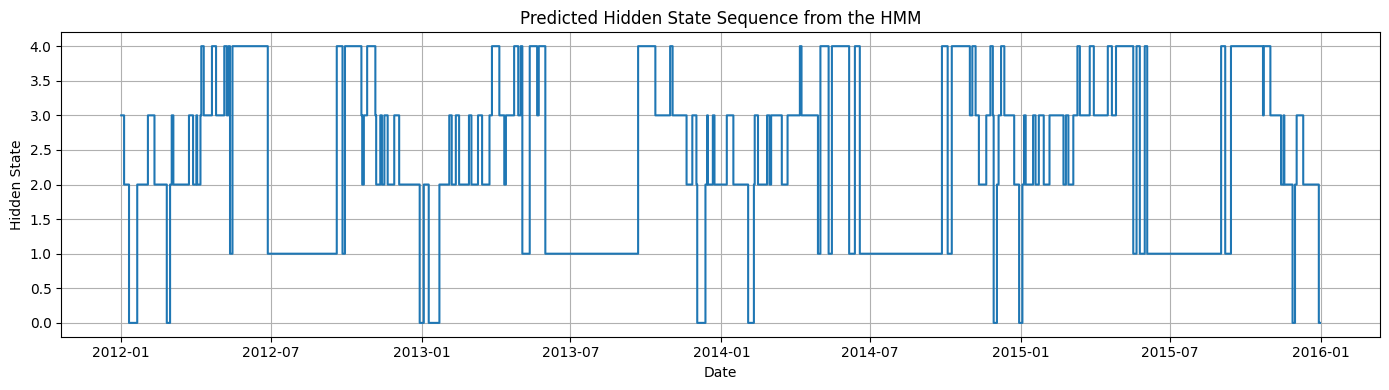


Training Comparison:


,Actual,Predicted
0,drizzle,snow
1,rain,snow
2,rain,snow
3,rain,snow
4,rain,sun



Testing Comparison:


,Actual,Predicted
0,rain,snow
1,rain,snow
2,rain,snow
3,rain,snow
4,sun,snow


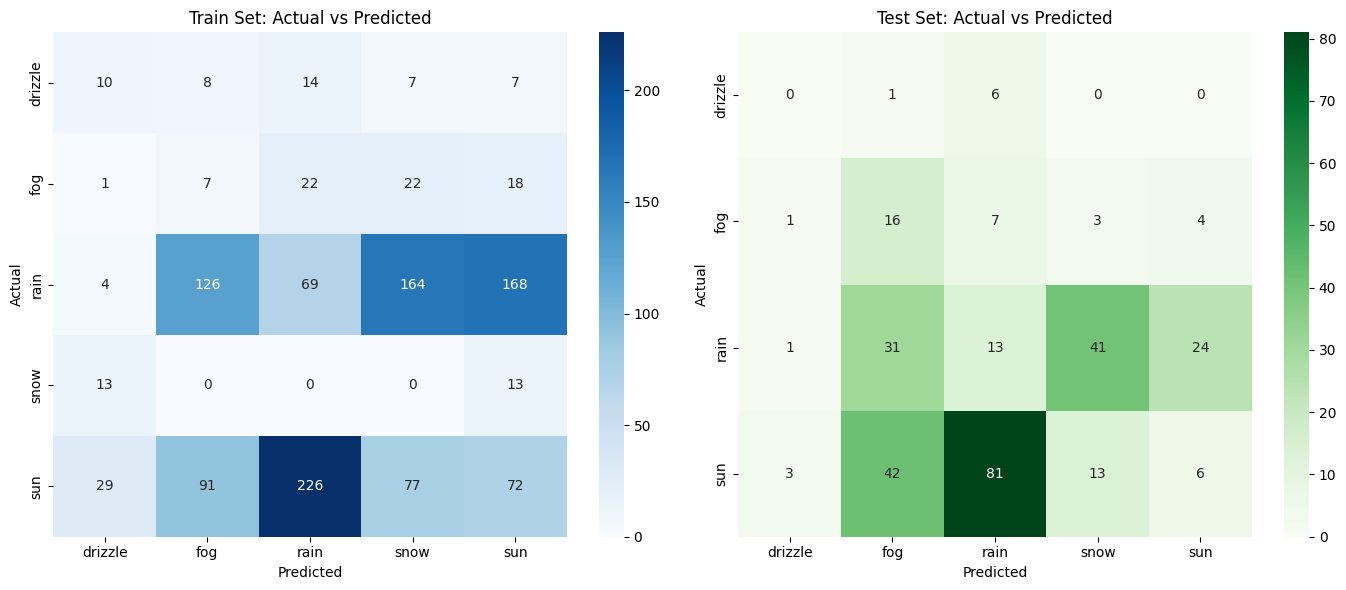

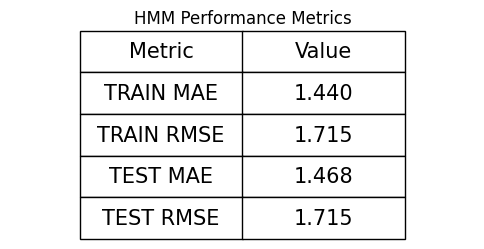


HMM Performance:
Training Set Accuracy: 13.53%
Testing Set Accuracy: 11.95%


In [20]:
class HiddenMarkovModel:
    def __init__(self, num_states, num_observations):
        """
        Initializes the HMM with random transition, emission, and initial state probabilities.
        
        Args:
            num_states (int): Number of hidden states.
            num_observations (int): Number of unique observations.
        """
        self.num_states = num_states
        self.num_observations = num_observations
        self.A = np.random.dirichlet(np.ones(num_states), num_states)  # Transition matrix
        self.B = np.random.dirichlet(np.ones(num_observations), num_states)  # Emission matrix
        self.pi = np.random.dirichlet(np.ones(num_states))  # Initial state distribution
        
        # Log-space versions to avoid underflow
        self.A_log = np.log(self.A + 1e-10)
        self.B_log = np.log(self.B + 1e-10)
        self.pi_log = np.log(self.pi + 1e-10)

    def forward_algorithm_log(self, O):
        """
        Forward algorithm in log-space.
        
        Args:
            O (np.array): Observation sequence (integers).
        
        Returns:
            alpha_log (np.array): Log-probability matrix of forward probabilities.
        
        TODO:
        - Implement the forward algorithm initialization and recursion in log-space.
        """
        T = len(O)
        N = self.num_states
        alpha_log = np.zeros((T, N))

        # TODO: Initialization step
        alpha_log[0] = self.pi_log + self.B_log[:, O[0]]  # Replace with initialization logic: log(α_0) = log(π) + log(B[:, O_0])

        # TODO: Recursion step
        for t in range(1, T):
            for j in range(N):
                alpha_log[t, j] = np.logaddexp.reduce(alpha_log[t - 1, :] + self.A_log[:, j]) + self.B_log[j, O[t]]  # Replace with recursion logic

        return alpha_log

    def backward_algorithm_log(self, O):
        """
        Backward algorithm in log-space.
        
        Args:
            O (np.array): Observation sequence (integers).
        
        Returns:
            beta_log (np.array): Log-probability matrix of backward probabilities.
        
        TODO:
        - Implement the backward algorithm initialization and recursion in log-space.
        """
        T = len(O)
        N = self.num_states
        beta_log = np.zeros((T, N))

        # TODO: Initialization step
        beta_log[-1] = 0  # log(1) = 0

        # TODO: Recursion step
        for t in range(T - 2, -1, -1):
            for i in range(N):
                beta_log[t, i] = np.logaddexp.reduce(
                    self.A_log[i, :] + self.B_log[:, O[t + 1]] + beta_log[t + 1, :]
                )  # Replace with recursion logic

        return beta_log

    def baum_welch_log(self, O, max_iter=100, epsilon=1e-6):
        """
        Baum-Welch algorithm for training HMM in log-space.
        
        Args:
            O (np.array): Observation sequence (integers).
            max_iter (int): Maximum number of iterations.
            epsilon (float): Small value to prevent division by zero.
        
        Returns:
            Trained transition, emission, and initial state distributions.
        
        TODO:
        - Implement the update steps for transition and emission probabilities.
        """
        T = len(O)
        
        for iteration in range(max_iter):
            # TODO: Call forward_algorithm_log and backward_algorithm_log
            alpha_log = self.forward_algorithm_log(O)
            beta_log = self.backward_algorithm_log(O)
            
            # Compute gamma and xi in log-space
            gamma_log = alpha_log + beta_log - np.logaddexp.reduce(alpha_log[-1])
            xi_log = np.zeros((T - 1, self.num_states, self.num_states))

            for t in range(T - 1):
                logits = (
                    alpha_log[t][:, None]
                    + self.A_log
                    + self.B_log[:, O[t + 1]][None, :]
                    + beta_log[t + 1][None, :]
                )
                denom_log = np.logaddexp.reduce(logits.flatten())
                for i in range(self.num_states):
                    for j in range(self.num_states):
                        xi_log[t, i, j] = logits[i, j] - denom_log  # Replace with logic for computing xi_log

            # TODO: Update A_log, B_log, and pi_log
            self.A_log = np.logaddexp.reduce(xi_log, axis=0) - np.logaddexp.reduce(
                gamma_log[:-1], axis=0
            )[:, None]

            new_B_log = np.full((self.num_states, self.num_observations), -np.inf)
            for k in range(self.num_observations):
                mask = (O == k)
                if np.any(mask):
                    new_B_log[:, k] = np.logaddexp.reduce(gamma_log[mask], axis=0)
            self.B_log = new_B_log - np.logaddexp.reduce(gamma_log, axis=0)[:, None]

            self.pi_log = gamma_log[0]

        return np.exp(self.A_log), np.exp(self.B_log), np.exp(self.pi_log)

    def viterbi_algorithm_log(self, O):
        """
        Viterbi algorithm for finding the most likely state sequence in log-space.
        
        Args:
            O (np.array): Observation sequence (integers).
        
        Returns:
            states (np.array): Most likely state sequence.
        
        TODO:
        - Implement the Viterbi algorithm's initialization and recursion steps.
        """
        T = len(O)
        N = self.num_states
        delta_log = np.zeros((T, N))
        psi = np.zeros((T, N), dtype=int)

        # TODO: Initialization step
        delta_log[0] = self.pi_log + self.B_log[:, O[0]]  # Replace with initialization logic

        # TODO: Recursion step
        for t in range(1, T):
            for j in range(N):
                temp = delta_log[t - 1] + self.A_log[:, j]
                psi[t, j] = np.argmax(temp)
                delta_log[t, j] = np.max(temp) + self.B_log[j, O[t]]

        # TODO: Path backtracking
        states = np.zeros(T, dtype=int)
        states[-1] = np.argmax(delta_log[-1])  # Replace with logic for the final state
        for t in range(T - 2, -1, -1):
            states[t] = psi[t + 1, states[t + 1]]  # Replace with path backtracking logic

        return states

# Main function with TODOs for students to complete
if __name__ == "__main__":
    # Load and preprocess the weather dataset
    weather_df = pd.read_csv("seattle-weather.csv", parse_dates=True, index_col=0)
    weather_df = weather_df[['temp_max', 'temp_min', 'weather']].dropna()
  

    # Calculate the average temperature and encode the 'weather' column
    weather_df['temp_avg'] = (weather_df['temp_max'] + weather_df['temp_min']) / 2

    weather_mapping = {label: idx for idx, label in enumerate(weather_df['weather'].unique())}
    reverse_weather_mapping = {v: k for k, v in weather_mapping.items()}
    weather_df['weather_encoded'] = weather_df['weather'].map(weather_mapping)

    # Convert average temperature to integer values for the observation sequence
    temp_min = weather_df['temp_avg'].min()
    O = (weather_df['temp_avg'] - temp_min).astype(int).values  # Observation sequence

    # Split data into training and testing sets
    train_size = int(0.8 * len(O))
    O_train = O[:train_size]
    O_test = O[train_size:]
    actual_train = weather_df['weather_encoded'].values[:train_size]
    actual_test = weather_df['weather_encoded'].values[train_size:]

    # Initialize and train the HMM
    num_states = len(weather_mapping)
    num_observations = O.max() + 1
    hmm = HiddenMarkovModel(num_states, num_observations)

    # TODO: Train the HMM using Baum-Welch on training data
    A_trained, B_trained, pi_trained = hmm.baum_welch_log(O_train)

    # TODO: Use the Viterbi algorithm for decoding the most likely state sequence
    train_predicted_states = hmm.viterbi_algorithm_log(O_train)
    test_predicted_states = hmm.viterbi_algorithm_log(O_test)

    plt.figure(figsize=(14, 4))

    full_pred = np.concatenate([train_predicted_states, test_predicted_states])
    
    plt.plot(weather_df.index, full_pred, drawstyle="steps-mid")
    plt.title("Predicted Hidden State Sequence from the HMM")
    plt.xlabel("Date")
    plt.ylabel("Hidden State")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    # Decode predicted states
    train_decoded_states = [reverse_weather_mapping[s] for s in train_predicted_states]
    test_decoded_states = [reverse_weather_mapping[s] for s in test_predicted_states]


    # TODO: Create and display comparison DataFrames for train and test sets
    train_df = pd.DataFrame({
    "Actual": [reverse_weather_mapping[s] for s in actual_train],
    "Predicted": train_decoded_states
    })
    
    test_df = pd.DataFrame({
        "Actual": [reverse_weather_mapping[s] for s in actual_test],
        "Predicted": test_decoded_states
    })
    
    print("\nTraining Comparison:")
    display(train_df.head())
    
    print("\nTesting Comparison:")
    display(test_df.head())

    import seaborn as sns

    plt.figure(figsize=(14, 6))
    
    # TRAIN plot
    plt.subplot(1, 2, 1)
    train_counts = pd.crosstab(train_df["Actual"], train_df["Predicted"])
    sns.heatmap(train_counts, annot=True, fmt="d", cmap="Blues")
    plt.title("Train Set: Actual vs Predicted")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    
    # TEST plot
    plt.subplot(1, 2, 2)
    test_counts = pd.crosstab(test_df["Actual"], test_df["Predicted"])
    sns.heatmap(test_counts, annot=True, fmt="d", cmap="Greens")
    plt.title("Test Set: Actual vs Predicted")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    
    plt.tight_layout()
    plt.show()


    # TODO: Evaluate accuracy for training and testing sets
    train_accuracy = np.mean(train_predicted_states == actual_train)
    test_accuracy = np.mean(test_predicted_states == actual_test)

    
    train_mae = mean_absolute_error(actual_train, train_predicted_states)
    train_rmse = np.sqrt(mean_squared_error(actual_train, train_predicted_states))
    test_mae = mean_absolute_error(actual_test, test_predicted_states)
    test_rmse = np.sqrt(mean_squared_error(actual_test, test_predicted_states))

    
    fig, ax = plt.subplots(figsize=(6, 2))
    ax.axis('tight')
    ax.axis('off')
    
    table_values = [
        ["TRAIN MAE", f"{train_mae:.3f}"],
        ["TRAIN RMSE", f"{test_rmse:.3f}"],
        ["TEST MAE", f"{test_mae:.3f}"],
        ["TEST RMSE", f"{test_rmse:.3f}"]
    ]
    
    table = ax.table(
        cellText=table_values,
        colLabels=["Metric", "Value"],
        loc='center',
        cellLoc='center'
    )
    
    table.auto_set_font_size(False)
    table.set_fontsize(15)
    table.scale(0.7, 2.5)
    
    plt.title("HMM Performance Metrics", pad=25)
    plt.show()

    

    print("\nHMM Performance:")
    print(f"Training Set Accuracy: {train_accuracy:.2%}")
    print(f"Testing Set Accuracy: {test_accuracy:.2%}")
